In [ ]:
#Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Download dataset
!gdown --id 1nkGxoRxdwr5sqqO8IS5W8Q0UdmugRd5j

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1nkGxoRxdwr5sqqO8IS5W8Q0UdmugRd5j
To: /content/gambarperkategori.zip
100% 5.49G/5.49G [00:58<00:00, 94.6MB/s]


In [ ]:
# Mengekstrak file gambar
import os
import zipfile

local_zip = '/content/gambarperkategori.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/gambarperkategori')
zip_ref.close()

In [ ]:
import os
import random
import shutil

# Path ke direktori data asli
data_dir = '/content/gambarperkategori'

# Path ke direktori baru untuk folder train, validation, dan test
os.makedirs('/content/dataset/', exist_ok=True)
train_dir = '/content/dataset/train/'
validation_dir = '/content/dataset/valid'
test_dir = '/content/dataset/test'

# Persentase pembagian data 
train_ratio = 0.95
validation_ratio = 0.025
test_ratio = 0.025

# Membuat folder train, validation, dan test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Mendapatkan daftar folder kelas dalam direktori data
class_folders = os.listdir(data_dir)

# Memindahkan data dari masing-masing folder kelas ke folder train, validation, dan test
for class_folder in class_folders:
    class_dir = os.path.join(data_dir, class_folder)
    files = os.listdir(class_dir)
    num_files = len(files)
    num_train = int(train_ratio * num_files)
    num_validation = int(validation_ratio * num_files)

    # Mengacak urutan file
    random.shuffle(files)

    # Memindahkan file ke folder train
    for file_name in files[:num_train]:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(train_dir, class_folder, file_name)
        os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
        shutil.move(src_path, dst_path)

    # Memindahkan file ke folder validation
    for file_name in files[num_train:num_train + num_validation]:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(validation_dir, class_folder, file_name)
        os.makedirs(os.path.join(validation_dir, class_folder), exist_ok=True)
        shutil.move(src_path, dst_path)

    # Memindahkan file ke folder test
    for file_name in files[num_train + num_validation:]:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(test_dir, class_folder, file_name)
        os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)
        shutil.move(src_path, dst_path)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Path ke direktori dataset
train_data_dir = '/content/dataset/train'
validation_data_dir = '/content/dataset/valid'
test_data_dir = '/content/dataset/test'

# Menentukan ukuran batch, ukuran gambar, dan jumlah kelas
batch_size = 256
image_size = (224, 224)
num_classes = 24

# Pra-pemrosesan dan Augmentasi data
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,       
    width_shift_range = 0.2,     
    height_shift_range = 0.2,     
    horizontal_flip = True,        
    zoom_range = 0.2               
)

validation_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255) 

# Memuat data menggunakan generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 154085 images belonging to 24 classes.
Found 4043 images belonging to 24 classes.
Found 4077 images belonging to 24 classes.


#Mobilenet 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


# Load pre-trained MobileNetV2 model (tanpa lapisan klasifikasi terakhir)
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Membekukan lapisan-lapisan dasar MobileNetV2 agar tidak terlatih ulang
for layer in base_model.layers:
    layer.trainable = False

# Membangun model baru di atas base model
modelmn2 = Sequential()
modelmn2.add(base_model)
modelmn2.add(GlobalAveragePooling2D())
modelmn2.add(Dense(1024, activation='relu'))
modelmn2.add(Dense(512, activation='relu'))
modelmn2.add(Dense(24, activation='softmax'))

# Mengompilasi model
modelmn2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Accuracy'])

# Menampilkan ringkasan model
modelmn2.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 24)                12312     
                                                           

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callback ModelCheckpoint untuk menyimpan model 
checkpoint_filepath = '/content/drive/MyDrive/Capstone project/saved model/MobilenetV2 {epoch:02d}.h5'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_freq='epoch', save_best_only=False, save_weights_only=False, verbose=1)

# Callback EarlyStopping untuk menghentikan pelatihan jika terjadi kesalahan atau diinterupsi 
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4)

In [ ]:
# Menentukan jumlah langkah per epoch dan jumlah epoch
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
epochs = 15

# Melatih model menggunakan generator data
modelmn2.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

<ipython-input-14-5e12b1a29d40>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelmn2.fit_generator(


Epoch 1/15
601/601 [==============================] - ETA: 0s - loss: 1.7362 - Accuracy: 0.4643
Epoch 1: saving model to /content/drive/MyDrive/Capstone project/saved model/MobilenetV2 01.h5
601/601 [==============================] - 2395s 4s/step - loss: 1.7362 - Accuracy: 0.4643 - val_loss: 1.6040 - val_Accuracy: 0.5026
Epoch 2/15
601/601 [==============================] - ETA: 0s - loss: 1.6348 - Accuracy: 0.4957
Epoch 2: saving model to /content/drive/MyDrive/Capstone project/saved model/MobilenetV2 02.h5
601/601 [==============================] - 2380s 4s/step - loss: 1.6348 - Accuracy: 0.4957 - val_loss: 1.5348 - val_Accuracy: 0.5219
Epoch 3/15
601/601 [==============================] - ETA: 0s - loss: 1.5608 - Accuracy: 0.5168
Epoch 3: saving model to /content/drive/MyDrive/Capstone project/saved model/MobilenetV2 03.h5
601/601 [==============================] - 2399s 4s/step - loss: 1.5608 - Accuracy: 0.5168 - val_loss: 1.4957 - val_Accuracy: 0.5388
Epoch 4/15
601/601 [========

In [ ]:
# Path untuk menyimpan model
model_path = '/content/drive/MyDrive/Bangkit/saved model/mobilenetv2/model 1.h5'

# Menyimpan model ke file
modelmn2.save(model_path)

print("Model telah disimpan ke:", model_path)

Model telah disimpan ke: /content/drive/MyDrive/Bangkit/saved model/mobilenetv2 01.06.2023.h5


Saving keyboard mouse.jpg to keyboard mouse.jpg
1/1 [==============================] - 0s 25ms/step


(-0.5, 255.5, 255.5, -0.5)

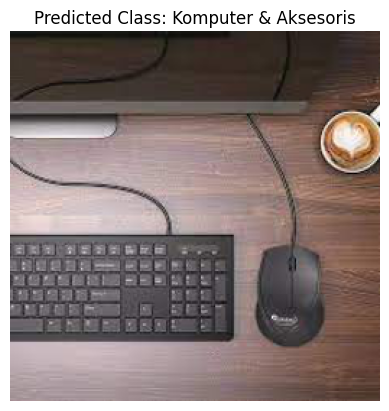

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
from PIL import Image

# Unggah gambar dari komputer
uploaded = files.upload()

# Mendapatkan path gambar yang diunggah
image_path = list(uploaded.keys())[0]
target_size = (224, 224)  # Ukuran target yang digunakan saat melatih model

# Mengubah gambar menjadi format yang dapat diterima oleh model
img = Image.open(image_path)
img = img.resize(target_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalisasi nilai piksel

# Melakukan prediksi menggunakan model
predictions = modelmn2.predict(img_array)
predicted_class = np.argmax(predictions)

# Mendapatkan label kelas dari indeks prediksi
class_labels = train_generator.class_indices
label = [k for k, v in class_labels.items() if v == predicted_class][0]

# Menampilkan gambar dengan label kelas
plt.imshow(img)
plt.title('Predicted Class: ' + label)
plt.axis('off')